In [6]:
!pip install pyod

In [7]:
from pyod.models.copod import COPOD # import Copula-Based Outlier Detection
import pandas as pd  
import numpy as np
import seaborn as sns
import os

if '.config' in os.listdir(): # check if we at local PC or on Collab
  from google.colab import drive
  drive.mount('/content/drive')
  path = "drive/MyDrive/Colab Notebooks/Diplom/project/"
    
else: 
  path = ''
  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Data and looking on the target variable

In [8]:
'''Loading reviews'''
rev = pd.read_csv(path + 'data/reviews/main_reviews.csv')
# Getting the mean value for several ratings:
rev = rev[['id','rating']].groupby('id')['rating'].mean().reset_index()
rev.columns = ['id','rating']

In [9]:
"""RAM data:"""
ram = pd.read_csv(path + 'data/datasets/ram.csv')
ram.head()


,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank
0,KINGSTON-FURY-KF429S17IBK2-32,Kingston Fury Impact DDR4 2x16Gb KF429S17IBK2/32,14980,https://www.e-katalog.ru/KINGSTON-FURY-KF429S1...,32,2,0,0,2933,23400,17,1.20,0,0,0,5,1
1,HYPERX-HX424C15FB3A-16,HyperX Fury DDR4 RGB 1x16Gb HX424C15FB3A/16,5850,https://www.e-katalog.ru/HYPERX-HX424C15FB3A-1...,16,1,1,0,2400,19200,15,1.20,1,1,1,30,2
2,NEO-FORZA-NMUD480E82-3200DB21,Neo Forza Faye DDR4 2x8Gb NMUD480E82-3200DB21,6290,https://www.e-katalog.ru/NEO-FORZA-NMUD480E82-...,16,2,1,0,3200,25600,16,1.35,1,0,0,11,1
3,HYNIX-HMT42GR7AFR4C-RD,Hynix HMT DDR3 1x16Gb HMT42GR7AFR4C-RD,9362,https://www.e-katalog.ru/HYNIX-HMT42GR7AFR4C-R...,16,1,1,1,1866,14900,13,1.50,0,0,0,12,1
4,KINGSTON-KCP426NS8-16,Kingston KCP ValueRAM DDR4 1x16Gb KCP426NS8/16,5510,https://www.e-katalog.ru/KINGSTON-KCP426NS8-16...,16,1,1,0,2666,21300,19,1.20,0,0,0,13,1


count      2023.000000
mean      12551.943154
std       22998.320606
min         500.000000
25%        3000.000000
50%        6230.000000
75%       12890.000000
max      299410.000000
Name: price, dtype: float64

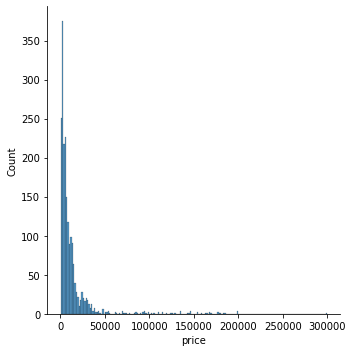

In [10]:
sns.displot(ram.price)
ram.price.describe()

We can see a big tail with high prices, this values are not suitable for the main task 

### Unsupervised training

count    2023.000000
mean       10.828372
std         3.981372
min         5.252321
25%         7.737501
50%         9.786891
75%        13.157924
max        29.261224
Name: anomaly_score, dtype: float64

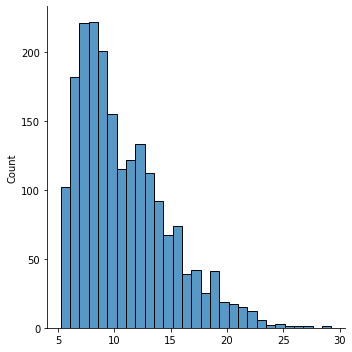

In [11]:
X = ram.drop(['id','name','link'],axis= 1)# prepare data for model 
detector = COPOD()# creating detector
scores = detector.decision_function(X)# Let the detector find anomalies without teacher
ram['anomaly_score'] = scores
# Let's look at the distribution of predicted anomalies
sns.displot(scores)
ram.anomaly_score.describe()

In [12]:
'''Checking result'''
ram[ram.anomaly_score > np.percentile(ram.anomaly_score,99)].head(5)

,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank,anomaly_score
30,SILICON-POWER-SP002GBLTU133S02,Silicon Power DDR3 1x2Gb SP002GBLTU133S02,650,https://www.e-katalog.ru/SILICON-POWER-SP002GB...,2,1,1,1,1333,10600,9,1.50,0,0,0,133,1,22.423759
224,CORSAIR-TR3X6G1333C7,Corsair XMS3 DDR3 TR3X6G1333C7,10000,https://www.e-katalog.ru/CORSAIR-TR3X6G1333C7.htm,6,3,1,1,1333,10600,7,1.65,1,1,0,133,1,29.261224
732,OWC-OWC8566DDR3S8GB,OWC DDR3 SO-DIMM OWC8566DDR3S8GB,5170,https://www.e-katalog.ru/OWC-OWC8566DDR3S8GB.htm,8,1,0,1,1066,8500,7,1.50,0,0,0,68,1,23.469950
796,SILICON-POWER-SP004GBVTU160N02,Silicon Power DDR3 1x4Gb SP004GBVTU160N02,1800,https://www.e-katalog.ru/SILICON-POWER-SP004GB...,4,1,1,1,1600,12800,4,1.65,0,0,0,86,1,22.403452
821,OWC-OWC8566DDR3S16P,OWC DDR3 SO-DIMM OWC8566DDR3S16P,10010,https://www.e-katalog.ru/OWC-OWC8566DDR3S16P.htm,16,2,0,1,1066,8500,7,1.50,0,0,0,68,1,24.981104


There are some exremely high prices, it doesn't suit us.

### Supervised training

In [13]:
'''Here I'll make a synthetic dataset with lower prices to fit the model'''
ram.drop('anomaly_score',axis= 1,inplace=True)# above results can be dropped now
synth_ouliers = ram.copy()
synth_ouliers.drop(['id','name','link'],axis= 1,inplace=True)
synth_ouliers.price = synth_ouliers.price*0.1
synth_ouliers.freq = synth_ouliers.freq*1.2

count    2023.000000
mean        0.241586
std         0.162464
min         0.003300
25%         0.113700
50%         0.213500
75%         0.334500
max         0.984200
Name: probabilities, dtype: float64

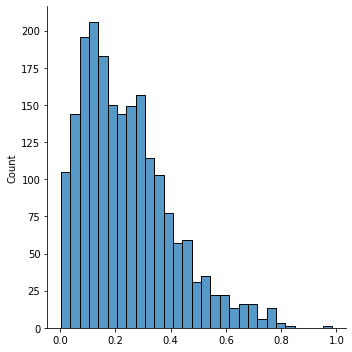

In [14]:
clf = COPOD(contamination =0.3)
clf.fit(synth_ouliers)
probabilities = clf.predict_proba(X)[:,1]# probabilities of normal values
ram['probabilities'] = np.round(probabilities,4)
sns.displot(probabilities)
ram.probabilities.describe()

It's quite strange that are so many outliers predicted, but let's take a look on the results 

### Evaluating model

In [15]:
ram.sort_values('probabilities').head(5)

,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank,probabilities
536,CRUCIAL-CT8G4DFRA266,Crucial Value DDR4 1x8Gb CT8G4DFRA266,2300,https://www.e-katalog.ru/CRUCIAL-CT8G4DFRA266.htm,8,1,1,0,2666,21300,19,1.2,0,0,0,15,1,0.0033
755,HIKVISION-HKED4081CBA1D0ZA1-8G,Hikvision DDR4 1x8Gb HKED4081CBA1D0ZA1/8G,2444,https://www.e-katalog.ru/HIKVISION-HKED4081CBA...,8,1,1,0,2666,21300,19,1.2,0,0,0,12,1,0.0039
1569,EXEGATE-EX283082RUS,ExeGate Value DIMM DDR4 1x8Gb EX283082RUS,2340,https://www.e-katalog.ru/EXEGATE-EX283082RUS.htm,8,1,1,0,2666,21300,19,1.2,0,0,0,11,1,0.0047
273,EXEGATE-EX288050RUS,ExeGate HiPower DIMM DDR4 1x8Gb EX288050RUS,2340,https://www.e-katalog.ru/EXEGATE-EX288050RUS.htm,8,1,1,0,2666,21300,19,1.2,0,0,0,11,1,0.0047
1842,NETAC-NTBSD4P26SP-08,Netac DDR4 1x8Gb NTBSD4P26SP-08,2370,https://www.e-katalog.ru/NETAC-NTBSD4P26SP-08.htm,8,1,1,0,2666,21300,19,1.2,0,0,0,11,1,0.0050


Looks better than unsupervised predictions 

### Evaluating model 

In [16]:
'''Let's compare results with simple sorting by lower price'''

ram[ram.volume == 4].sort_values('price').head(5) # 4Gb 

,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank,probabilities
1250,SAMSUNG-M471B5173DB0-YK0,Samsung DDR3 SO-DIMM 1x4Gb M471B5173DB0-YK0,1198,https://www.e-katalog.ru/SAMSUNG-M471B5173DB0-...,4,1,0,1,1600,12800,11,1.35,0,0,0,29,1,0.2422
1515,CRUCIAL-CT4G4RFS824A,Crucial Value DDR4 1x4Gb CT4G4RFS824A,1200,https://www.e-katalog.ru/CRUCIAL-CT4G4RFS824A.htm,4,1,1,0,2400,19200,17,1.20,0,0,0,45,1,0.0568
275,PATRIOT-MEMORY-PSD34G16002,Patriot Memory Signature DDR3 1x4Gb PSD34G16002,1220,https://www.e-katalog.ru/PATRIOT-MEMORY-PSD34G...,4,1,1,1,1600,12800,9,1.60,0,0,0,104,1,0.5009
1376,AMD-R744G2400S1S-UO,AMD Value Edition SO-DIMM DDR4 1x4Gb R744G2400...,1226,https://www.e-katalog.ru/AMD-R744G2400S1S-UO.htm,4,1,0,0,2400,19200,17,1.20,0,0,0,45,1,0.1226
6,HYNIX-HMT451U6AFR8C-PBN0,Hynix HMT DDR3 1x4Gb HMT451U6AFR8C-PBN0,1250,https://www.e-katalog.ru/HYNIX-HMT451U6AFR8C-P...,4,1,1,1,1600,12800,11,1.50,0,0,0,92,1,0.3071


In [17]:
ram[ram.volume == 4].sort_values(['probabilities']).head(5)

,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank,probabilities
727,AMD-R744G2606U1S-U,AMD R7 Performance DDR4 1x4Gb R744G2606U1S-U,1330,https://www.e-katalog.ru/AMD-R744G2606U1S-U.htm,4,1,1,0,2666,21300,16,1.2,0,0,0,12,1,0.0131
281,NEO-FORZA-NMUD440D82-2666EA10,Neo Forza DDR4 1x4Gb NMUD440D82-2666EA10,1860,https://www.e-katalog.ru/NEO-FORZA-NMUD440D82-...,4,1,1,0,2666,21300,17,1.2,0,0,0,11,1,0.0161
1049,CRUCIAL-CT4G4DFS6266,Crucial Value DDR4 1x4Gb CT4G4DFS6266,1680,https://www.e-katalog.ru/CRUCIAL-CT4G4DFS6266.htm,4,1,1,0,2666,21300,19,1.2,0,0,0,12,1,0.0169
1233,KINGSTON-KVR26N19S6L-4,Kingston KVR ValueRAM DDR4 1x4Gb KVR26N19S6L/4,1800,https://www.e-katalog.ru/KINGSTON-KVR26N19S6L-...,4,1,1,0,2666,21300,19,1.2,0,0,0,13,1,0.0169
1510,SILICON-POWER-SP004GBLFU266N02,Silicon Power DDR4 1x4Gb SP004GBLFU266N02,1673,https://www.e-katalog.ru/SILICON-POWER-SP004GB...,4,1,1,0,2666,21300,19,1.2,0,0,0,13,1,0.0170


We see that model advising us not just cheap product, but with better frequency - 2666 and wider bandwidth - 21300

In [18]:
ram[ram.n_planks == 4].sort_values('price').head(5) # 4 planks

,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank,probabilities
49,HYPERX-HX426C16FB3K4-16,HyperX Fury Black DDR4 4x4Gb HX426C16FB3K4/16,5325,https://www.e-katalog.ru/HYPERX-HX426C16FB3K4-...,16,4,1,0,2666,21300,16,1.20,1,1,0,29,1,0.1871
612,HYPERX-HX432C16FB3K4-16,HyperX Fury Black DDR4 4x4Gb HX432C16FB3K4/16,7275,https://www.e-katalog.ru/HYPERX-HX432C16FB3K4-...,16,4,1,0,3200,24000,16,1.35,1,1,0,29,1,0.2207
88,KINGSTON-FURY-KF426C16BBK4-16,Kingston Fury Beast DDR4 4x4Gb KF426C16BBK4/16,8810,https://www.e-katalog.ru/KINGSTON-FURY-KF426C1...,16,4,1,0,2666,21300,16,1.20,1,1,0,7,1,0.2089
784,HYPERX-HX430C15FB3K4-16,HyperX Fury Black DDR4 4x4Gb HX430C15FB3K4/16,9110,https://www.e-katalog.ru/HYPERX-HX430C15FB3K4-...,16,4,1,0,3000,24000,15,1.35,1,1,0,29,1,0.2371
572,KINGSTON-FURY-KF432C16BBK4-16,Kingston Fury Beast DDR4 4x4Gb KF432C16BBK4/16,9584,https://www.e-katalog.ru/KINGSTON-FURY-KF432C1...,16,4,1,0,3200,25600,16,1.35,1,1,0,7,1,0.2340


In [19]:
ram[ram.n_planks == 4].sort_values('probabilities').head(5) # 4 planks

,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank,probabilities
49,HYPERX-HX426C16FB3K4-16,HyperX Fury Black DDR4 4x4Gb HX426C16FB3K4/16,5325,https://www.e-katalog.ru/HYPERX-HX426C16FB3K4-...,16,4,1,0,2666,21300,16,1.20,1,1,0,29,1,0.1871
88,KINGSTON-FURY-KF426C16BBK4-16,Kingston Fury Beast DDR4 4x4Gb KF426C16BBK4/16,8810,https://www.e-katalog.ru/KINGSTON-FURY-KF426C1...,16,4,1,0,2666,21300,16,1.20,1,1,0,7,1,0.2089
612,HYPERX-HX432C16FB3K4-16,HyperX Fury Black DDR4 4x4Gb HX432C16FB3K4/16,7275,https://www.e-katalog.ru/HYPERX-HX432C16FB3K4-...,16,4,1,0,3200,24000,16,1.35,1,1,0,29,1,0.2207
572,KINGSTON-FURY-KF432C16BBK4-16,Kingston Fury Beast DDR4 4x4Gb KF432C16BBK4/16,9584,https://www.e-katalog.ru/KINGSTON-FURY-KF432C1...,16,4,1,0,3200,25600,16,1.35,1,1,0,7,1,0.2340
784,HYPERX-HX430C15FB3K4-16,HyperX Fury Black DDR4 4x4Gb HX430C15FB3K4/16,9110,https://www.e-katalog.ru/HYPERX-HX430C15FB3K4-...,16,4,1,0,3000,24000,15,1.35,1,1,0,29,1,0.2371


Model choosing lower voltage, on some systems it matters

In [20]:
ram[ram.ddr3 == 1].sort_values('price').head(5) # ddr3

,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank,probabilities
849,FOXLINE-FL1333D3SO9-1G,Foxline DDR3 SO-DIMM FL1333D3SO9-1G,500,https://www.e-katalog.ru/FOXLINE-FL1333D3SO9-1...,1,1,0,1,1333,10600,9,1.5,0,0,0,82,1,0.5795
30,SILICON-POWER-SP002GBLTU133S02,Silicon Power DDR3 1x2Gb SP002GBLTU133S02,650,https://www.e-katalog.ru/SILICON-POWER-SP002GB...,2,1,1,1,1333,10600,9,1.5,0,0,0,133,1,0.5628
162,KINGSTON-KVR16N11S6-2,Kingston KVR ValueRAM DDR3 1x2Gb KVR16N11S6/2,700,https://www.e-katalog.ru/KINGSTON-KVR16N11S6-2...,2,1,1,1,1600,12800,11,1.5,0,0,0,92,1,0.3516
69,KINGSTON-KVR16N11-2,Kingston KVR ValueRAM DDR3 1x2Gb KVR16N11/2,700,https://www.e-katalog.ru/KINGSTON-KVR16N11-2.htm,2,1,1,1,1600,12800,11,1.5,0,0,0,109,1,0.3859
48,SILICON-POWER-SP002GBLTU133V01,Silicon Power DDR3 1x2Gb SP002GBLTU133V01,700,https://www.e-katalog.ru/SILICON-POWER-SP002GB...,2,1,1,1,1333,10600,9,1.5,0,0,0,81,1,0.4494


In [21]:
ram[ram.ddr3 == 1].sort_values('probabilities').head(5) # ddr3

,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank,probabilities
938,AMD-R538G1601U2SL-U,AMD R5 Entertainment DDR3 1x8Gb R538G1601U2SL-U,2154,https://www.e-katalog.ru/AMD-R538G1601U2SL-U.htm,8,1,1,1,1600,12800,11,1.35,0,0,0,14,1,0.1546
1781,NEO-FORZA-NMUD380D81-1600DA10,Neo Forza DDR3 1x8Gb NMUD380D81-1600DA10,2743,https://www.e-katalog.ru/NEO-FORZA-NMUD380D81-...,8,1,1,1,1600,12800,11,1.35,0,0,0,10,1,0.1657
75,AMD-R534G1601U1SL-U,AMD R5 Entertainment DDR3 1x4Gb R534G1601U1SL-U,1390,https://www.e-katalog.ru/AMD-R534G1601U1SL-U.htm,4,1,1,1,1600,12800,11,1.35,0,0,0,14,1,0.1704
779,NEO-FORZA-NMUD340C81-1600DA10,Neo Forza DDR3 1x4Gb NMUD340C81-1600DA10,1695,https://www.e-katalog.ru/NEO-FORZA-NMUD340C81-...,4,1,1,1,1600,12800,11,1.35,0,0,0,10,1,0.1753
1111,FOXLINE-FL1600LE11-8G,Foxline DDR3 DIMM FL1600LE11-8G,3643,https://www.e-katalog.ru/FOXLINE-FL1600LE11-8G...,8,1,1,1,1600,12800,11,1.35,0,0,0,40,1,0.1815


Model shows better frequency again

In [22]:
'''Let's  make a complex request  and compare results with mean price'''

print('Mean price:',
np.round(
ram[(ram.ddr3 == 0) & # DDR 4
     (ram.volume == 8) & # 8GB
     (ram.n_planks == 1) & # one plank 
     (ram.freq == 2666) # 2666Hz
     ].price.mean()))

ram[(ram.ddr3 == 0)& 
     (ram.volume == 8)& 
     (ram.n_planks == 1)].sort_values(['probabilities']).head(5)
                      

Mean price: 4277.0


,id,name,price,link,volume,n_planks,dimm,ddr3,freq,bandwidth,cas,voltage,cooling,overclock,lighting,age,rank,probabilities
536,CRUCIAL-CT8G4DFRA266,Crucial Value DDR4 1x8Gb CT8G4DFRA266,2300,https://www.e-katalog.ru/CRUCIAL-CT8G4DFRA266.htm,8,1,1,0,2666,21300,19,1.2,0,0,0,15,1,0.0033
755,HIKVISION-HKED4081CBA1D0ZA1-8G,Hikvision DDR4 1x8Gb HKED4081CBA1D0ZA1/8G,2444,https://www.e-katalog.ru/HIKVISION-HKED4081CBA...,8,1,1,0,2666,21300,19,1.2,0,0,0,12,1,0.0039
1569,EXEGATE-EX283082RUS,ExeGate Value DIMM DDR4 1x8Gb EX283082RUS,2340,https://www.e-katalog.ru/EXEGATE-EX283082RUS.htm,8,1,1,0,2666,21300,19,1.2,0,0,0,11,1,0.0047
273,EXEGATE-EX288050RUS,ExeGate HiPower DIMM DDR4 1x8Gb EX288050RUS,2340,https://www.e-katalog.ru/EXEGATE-EX288050RUS.htm,8,1,1,0,2666,21300,19,1.2,0,0,0,11,1,0.0047
1842,NETAC-NTBSD4P26SP-08,Netac DDR4 1x8Gb NTBSD4P26SP-08,2370,https://www.e-katalog.ru/NETAC-NTBSD4P26SP-08.htm,8,1,1,0,2666,21300,19,1.2,0,0,0,11,1,0.0050


Prices in the table are lower in about two times than mean value 

In [23]:
ram = ram.merge(rev,on='id',how='left')
ram.rating = ram.rating.fillna(2)
ram.to_csv(path + 'data/bot_data/ram.csv',index= False)

### Conclusions.
* Supervised model has shown satisfactory results for the business task.
* It can be used in production for the RAM.
* I'll scale it for the other products for the beginning and check how it works.
  


In [24]:
"""Notebooks data:"""
note = pd.read_csv(path + 'data/datasets/notebooks.csv')
note.head()


,id,name,price,link,diagonal,display_res,frame_rate,bright,cores,threads,clock_freq,turbo_freq,l2_cashe,l3_cashe,passmark_test,ram_vol,max_ram_vol,ddr4,ram_freq,ram_slots,discrete_video,video_ram_vol,drive_vol,usb_2,usb_3_g1,usb_3_g2,usb_c_g1,usb_c_g2,camera,dynamics,bat_capacity,max_work_time,weight,age,3dmark,add_m2,usb4,thunderbolt,max_monitors,height,...,video_ram_type_0,video_ram_type_1,video_ram_type_2,drive_type_0,drive_type_1,drive_type_2,drive_type_3,drive_type_4,drive_type_5,drive_type_6,drive_type_7,drive_type_8,m2_interface_0,m2_interface_1,m2_interface_2,m2_interface_3,m2_interface_4,wi_fi_0,wi_fi_1,op_sys_0,op_sys_1,op_sys_2,op_sys_3,op_sys_4,op_sys_5,op_sys_6,op_sys_7,op_sys_8,op_sys_9,op_sys_10,op_sys_11,op_sys_12,op_sys_13,cardreader_0,cardreader_1,cardreader_2,cardreader_3,cardreader_4,cardreader_5,cardreader_6
0,/DELL-5402-5156.htm,Dell Vostro 14 5402 (5402-5156),68000,https://www.e-katalog.ru/DELL-5402-5156.htm,14.0,1920,60,220,4,8.0,2.4,4.2,5120,8,10004,8,32,1,3200,2,0,0.0,256,0,2,0,0,1,1280,2.0,42.672,8.0,1.36,9,9093,1,0,0,2.0,321,...,-0.67082,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-7.071068e-01,0.408248,-0.418330,0.472270,-0.456256,0.393641,-0.307724,0.219002,-0.141859,0.083314,-0.044039,0.020706,-0.008499,0.002954,-0.000820,0.000158,-0.540062,0.540062,-0.430820,0.282038,-0.149786,0.061546,-0.017070
1,/LENOVO-5-14ITL05-82FE00CQRK.htm,Lenovo IdeaPad 5 14ITL05 (5 14ITL05 82FE00CQRK),47452,https://www.e-katalog.ru/LENOVO-5-14ITL05-82FE...,14.0,1920,60,300,2,4.0,3.0,4.1,2560,6,6418,8,8,1,3200,0,0,0.0,512,0,2,0,1,0,1280,2.0,57.000,11.0,1.40,11,6331,0,0,0,2.0,322,...,-0.67082,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-4.433780e-17,-0.816497,-0.358569,0.269869,-0.065179,-0.168703,0.351684,-0.438004,0.425576,-0.345159,0.239071,-0.141982,0.071638,-0.029959,0.009845,-0.002210,-0.385758,0.077152,0.307729,-0.523785,0.492155,-0.307729,0.119488
2,/LENOVO-15-G2-ITL-20VE00M5RU.htm,Lenovo ThinkBook 15 G2 ITL (15 G2 ITL 20VE00M5RU),90650,https://www.e-katalog.ru/LENOVO-15-G2-ITL-20VE...,15.6,1920,60,300,4,8.0,2.4,4.2,5120,8,9747,8,40,1,3200,1,0,0.0,256,0,2,0,0,1,1280,2.0,45.000,6.0,1.70,3,9093,1,1,1,3.0,357,...,-0.67082,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-4.433780e-17,-0.816497,-0.418330,0.472270,-0.456256,0.393641,-0.307724,0.219002,-0.141859,0.083314,-0.044039,0.020706,-0.008499,0.002954,-0.000820,0.000158,-0.385758,0.077152,0.307729,-0.523785,0.492155,-0.307729,0.119488
3,/HP-435G8-4Y582EA.htm,HP ProBook x360 435 G8 (435G8 4Y582EA),84000,https://www.e-katalog.ru/HP-435G8-4Y582EA.htm,13.3,1920,60,250,6,12.0,2.3,4.2,3072,16,15941,16,32,1,3200,2,0,0.0,512,0,2,0,0,1,1280,2.0,45.480,17.0,1.45,1,11349,0,0,0,2.0,309,...,-0.67082,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.358569,-0.109109,0.521749,-0.566947,0.314970,-7.071068e-01,0.408248,-0.418330,0.472270,-0.456256,0.393641,-0.307724,0.219002,-0.141859,0.083314,-0.044039,0.020706,-0.008499,0.002954,-0.000820,0.000158,-0.540062,0.540062,-0.430820,0.282038,-0.149786,0.061546,-0.017070
4,/ASUS-P1440FA-FA2025T.htm,Asus PRO P1440FA (P1440FA-FA2025T) (90NX0211-M...,36680,https://www.e-katalog.ru/ASUS-P1440FA-FA2025T.htm,14.0,1920,60,250,2,4.0,2.1,4.1,1024,4,4208,4,20,1,2400,1,0,0.0,1000,1,3,0,0,0,1280,2.0,44.000,8.0,1.60,16,10514,1,0,0,0.0,340,...,-0.67082,0.5,-0.223607,-0.385337,0.174078,0.151142,-0.411377,0.501280,-0.428174,0.275179,-0.130893,0.040816,-0.358569,-0.109109,0.521749,-0.566947,0.314970,-7.071068e-01,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.300960,-0.084231,-0.185507,0.379950,-0.436039,0.371110,-0.248910,0.132074,-0.053325,0.014367,-0.231455,-0.231455,0.430820,-0.120873,-0.36376

count      3388.000000
mean      81708.811983
std       51674.116487
min        6734.000000
25%       45990.000000
50%       68999.500000
75%       99990.000000
max      420000.000000
Name: price, dtype: float64

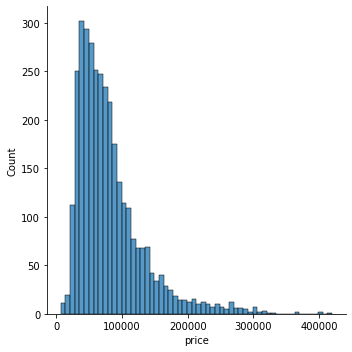

In [25]:
sns.displot(note.price)
note.price.describe()

In [26]:
'''Here I'll make a synthetic dataset with lower prices to fit the model'''

synth_ouliers = note.copy()
synth_ouliers.drop(['id','name','link'],axis= 1,inplace=True)
synth_ouliers.price = synth_ouliers.price*0.1


count    3388.000000
mean        0.208978
std         0.110259
min         0.002100
25%         0.124525
50%         0.199250
75%         0.275200
max         0.990000
Name: probabilities, dtype: float64

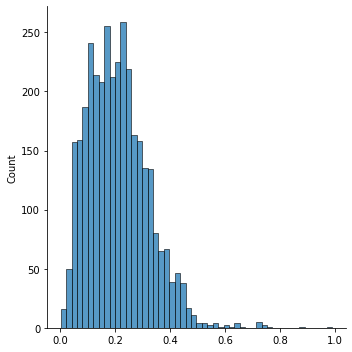

In [27]:
X = note.drop(['id','name','link'],axis= 1)# prepare data for model 
clf = COPOD(contamination =0.3)
clf.fit(synth_ouliers)
probabilities = clf.predict_proba(X)[:,1]# probabilities of normal values
note['probabilities'] = np.round(probabilities,4)
sns.displot(probabilities)
note.probabilities.describe()

In [28]:
note.sort_values('probabilities').head(5)

,id,name,price,link,diagonal,display_res,frame_rate,bright,cores,threads,clock_freq,turbo_freq,l2_cashe,l3_cashe,passmark_test,ram_vol,max_ram_vol,ddr4,ram_freq,ram_slots,discrete_video,video_ram_vol,drive_vol,usb_2,usb_3_g1,usb_3_g2,usb_c_g1,usb_c_g2,camera,dynamics,bat_capacity,max_work_time,weight,age,3dmark,add_m2,usb4,thunderbolt,max_monitors,height,...,video_ram_type_1,video_ram_type_2,drive_type_0,drive_type_1,drive_type_2,drive_type_3,drive_type_4,drive_type_5,drive_type_6,drive_type_7,drive_type_8,m2_interface_0,m2_interface_1,m2_interface_2,m2_interface_3,m2_interface_4,wi_fi_0,wi_fi_1,op_sys_0,op_sys_1,op_sys_2,op_sys_3,op_sys_4,op_sys_5,op_sys_6,op_sys_7,op_sys_8,op_sys_9,op_sys_10,op_sys_11,op_sys_12,op_sys_13,cardreader_0,cardreader_1,cardreader_2,cardreader_3,cardreader_4,cardreader_5,cardreader_6,probabilities
2969,/HP-15S-FQ2058UR-40K66EA.htm,HP 15s-fq2000 (15S-FQ2058UR 40K66EA),56999,https://www.e-katalog.ru/HP-15S-FQ2058UR-40K66...,15.6,1920,60,250,4,8.0,2.4,4.2,5120,8,9548,8,16,1,2666,2,0,0.0,512,0,2,0,1,0,1280,2.0,41.00,9.25,1.69,6,9093,0,0,0,0.0,359,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.119523,-0.436436,0.298142,0.377964,-0.629941,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.231455,-0.231455,0.43082,-0.120873,-0.363766,0.553912,-0.358464,0.0021
1885,/HP-15S-FQ2026UR-40K65EA.htm,HP 15s-fq2000 (15S-FQ2026UR 40K65EA),55546,https://www.e-katalog.ru/HP-15S-FQ2026UR-40K65...,15.6,1920,60,250,4,8.0,2.4,4.2,5120,8,9548,8,16,1,2666,2,0,0.0,512,0,2,0,1,0,1280,2.0,41.00,9.25,1.69,8,9093,0,0,0,0.0,359,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.119523,-0.436436,0.298142,0.377964,-0.629941,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.231455,-0.231455,0.43082,-0.120873,-0.363766,0.553912,-0.358464,0.0028
1843,/HP-15S-FQ2008UR-2X1F0EA.htm,HP 15s-fq2000 (15S-FQ2008UR 2X1F0EA),48990,https://www.e-katalog.ru/HP-15S-FQ2008UR-2X1F0...,15.6,1920,60,250,4,8.0,2.4,4.2,5120,8,9548,8,16,1,2666,2,0,0.0,512,0,2,0,1,0,1280,2.0,41.00,9.25,1.69,14,9093,0,0,0,0.0,359,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.119523,-0.436436,0.298142,0.377964,-0.629941,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.231455,-0.231455,0.43082,-0.120873,-0.363766,0.553912,-0.358464,0.0060
1908,/HP-15S-FQ2057UR-426A1EA.htm,HP 15s-fq2000 (15S-FQ2057UR 426A1EA),62900,https://www.e-katalog.ru/HP-15S-FQ2057UR-426A1...,15.6,1920,60,250,4,8.0,2.4,4.2,5120,8,9548,16,16,1,2666,2,0,0.0,512,0,2,0,1,0,1280,2.0,41.00,9.25,1.69,10,9093,0,0,0,0.0,359,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.119523,-0.436436,0.298142,0.377964,-0.629941,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.231455,-0.231455,0.43082,-0.120873,-0.363766,0.553912,-0.358464,0.0078
360,/HP-15-EG0101UR-49J67EA.htm,HP Pavilion 15-eg0000 (15-EG0101UR 49J67EA),64999,https://www.e-katalog.ru/HP-15-EG0101UR-49J67E...,15.6,1920,60,250,4,8.0,2.4,4.2,5120,8,9873,8,16,1,3200,2,0,0.0,512,0,2,0,0,1,1280,2.0,41.28,8.50,1.75,6,9093,0,0,0,2.0,360,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.119523,-0.436436,0.298142,0.377964,-0.629941,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.540062,0.540062,-0.43082,0.282038,-0.149786,0.061546,-0.017070,0.0111


In [29]:
'''Let's  make a complex request  and compare results with mean price'''

note[note.price.between(25000,35000)].sort_values(['probabilities']).head(5)

,id,name,price,link,diagonal,display_res,frame_rate,bright,cores,threads,clock_freq,turbo_freq,l2_cashe,l3_cashe,passmark_test,ram_vol,max_ram_vol,ddr4,ram_freq,ram_slots,discrete_video,video_ram_vol,drive_vol,usb_2,usb_3_g1,usb_3_g2,usb_c_g1,usb_c_g2,camera,dynamics,bat_capacity,max_work_time,weight,age,3dmark,add_m2,usb4,thunderbolt,max_monitors,height,...,video_ram_type_1,video_ram_type_2,drive_type_0,drive_type_1,drive_type_2,drive_type_3,drive_type_4,drive_type_5,drive_type_6,drive_type_7,drive_type_8,m2_interface_0,m2_interface_1,m2_interface_2,m2_interface_3,m2_interface_4,wi_fi_0,wi_fi_1,op_sys_0,op_sys_1,op_sys_2,op_sys_3,op_sys_4,op_sys_5,op_sys_6,op_sys_7,op_sys_8,op_sys_9,op_sys_10,op_sys_11,op_sys_12,op_sys_13,cardreader_0,cardreader_1,cardreader_2,cardreader_3,cardreader_4,cardreader_5,cardreader_6,probabilities
2091,/ASUS-X415EA-EK608T.htm,Asus X415EA (X415EA-EK608T) (90NB0TT2-M08560),34890,https://www.e-katalog.ru/ASUS-X415EA-EK608T.htm,14.0,1920,60,250,2,4.0,3.0,4.1,2560,6,6525,4,12,1,3200,1,0,0.0,256,2,1,0,1,0,640,2.0,37.0,9.00,1.60,3,6331,0,0,0,1.0,325,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,0.119523,-0.436436,-0.298142,0.377964,0.629941,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.540062,0.540062,-0.430820,0.282038,-0.149786,0.061546,-0.017070,0.0760
865,/HP-14S-DQ2007UR-2X1P1EA.htm,HP 14s-dq2000 (14S-DQ2007UR 2X1P1EA),32990,https://www.e-katalog.ru/HP-14S-DQ2007UR-2X1P1...,14.0,1920,60,250,2,4.0,2.0,3.5,2560,4,5537,4,16,1,2666,2,0,0.0,256,0,2,0,1,0,1280,2.0,41.0,9.75,1.46,11,11040,0,0,0,0.0,324,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.119523,-0.436436,0.298142,0.377964,-0.629941,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.231455,-0.231455,0.430820,-0.120873,-0.363766,0.553912,-0.358464,0.0780
332,/HP-14S-DQ2008UR-2X1P4EA.htm,HP 14s-dq2000 (14S-DQ2008UR 2X1P4EA),32288,https://www.e-katalog.ru/HP-14S-DQ2008UR-2X1P4...,14.0,1920,60,250,2,4.0,2.0,3.5,2560,4,5537,4,16,1,2666,2,0,0.0,256,0,2,0,1,0,1280,2.0,41.0,9.75,1.46,11,11040,0,0,0,0.0,324,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.119523,-0.436436,0.298142,0.377964,-0.629941,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.231455,-0.231455,0.430820,-0.120873,-0.363766,0.553912,-0.358464,0.0780
1180,/LENOVO-3-14ITL05-81X7007CRU.htm,Lenovo IdeaPad 3 14ITL05 (3 14ITL05 81X7007CRU),31789,https://www.e-katalog.ru/LENOVO-3-14ITL05-81X7...,14.0,1920,60,250,2,4.0,2.0,3.5,2560,4,5421,8,12,1,2666,1,0,0.0,128,1,2,0,0,0,640,2.0,35.0,6.00,1.50,5,11040,0,0,0,1.0,327,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.385758,0.077152,0.307729,-0.523785,0.492155,-0.307729,0.119488,0.0785
1896,/LENOVO-3-14ITL05-81X7007FRU.htm,Lenovo IdeaPad 3 14ITL05 (3 14ITL05 81X7007FRU),33926,https://www.e-katalog.ru/LENOVO-3-14ITL05-81X7...,14.0,1920,60,250,2,2.0,1.8,1.8,2560,4,2259,8,12,1,2666,1,0,0.0,256,1,2,0,0,0,640,2.0,35.0,6.00,1.50,5,11040,0,0,0,1.0,327,...,0.5,-0.223607,-0.495434,0.522233,-0.453425,0.336581,-0.214834,0.116775,-0.052694,0.018699,-0.004535,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-0.707107,0.408248,-0.298807,0.098606,0.175483,-0.341733,0.30096,-0.084231,-0.185507,0.37995,-0.436039,0.37111,-0.24891,0.132074,-0.053325,0.014367,-0.385758,0.077152,0.307729,-0.523785,0.492155,-0.307729,0.119488,0.0810


In [30]:
note = note.merge(rev,on='id',how='left')
note.rating = note.rating.fillna(2)
note.to_csv(path + 'data/bot_data/notebooks.csv',index =False)